<a href="https://colab.research.google.com/github/sinood/cs194-26_proj4_p3/blob/master/cs192_26_proj4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import random
import skimage as sk
import skimage.transform as sktr
import skimage.io as skio
import time
import matplotlib.pyplot as plt
from skimage.transform import resize

Load dataset

In [ ]:
import os 

if not os.path.exists('/content/ibug_300W_large_face_landmark_dataset'):
    !wget https://people.eecs.berkeley.edu/~zhecao/ibug_300W_large_face_landmark_dataset.zip
    !unzip 'ibug_300W_large_face_landmark_dataset.zip'    
    !rm -r 'ibug_300W_large_face_landmark_dataset.zip'

Loading the bounding boxes 

In [4]:
import xml.etree.ElementTree as ET 
import numpy as np


tree = ET.parse('ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml')
root = tree.getroot()
root_dir = 'ibug_300W_large_face_landmark_dataset'

bboxes = [] # face bounding box used to crop the image
landmarks = [] # the facial keypoints/landmarks for the whole training dataset
img_filenames = [] # the image names for the whole dataset

for filename in root[2]:
  img_filenames.append(os.path.join(root_dir, filename.attrib['file']))
  box = filename[0].attrib
  # x, y for the top left corner of the box, w, h for box width and height
  new_w = int(float(box['width']) * 1.2)
  new_h = int(float(box['height'])* 1.2)
  diff_x = int((new_w - float(box['width']))/2)
  diff_y = int((new_h - float(box['height']))/2)
  bboxes.append([float(box['left'])-diff_x, float(box['top'])-diff_y, new_w, new_h]) 

  landmark = []
  for num in range(68):
    x_coordinate = int(filename[0][num].attrib['x'])
    y_coordinate = int(filename[0][num].attrib['y'])
    landmark.append([x_coordinate, y_coordinate])
  landmarks.append(landmark)

landmarks = np.array(landmarks).astype('float32')     
bboxes = np.array(bboxes).astype('float32') 

# Get bounding boxes for test dataset
tree = ET.parse('ibug_300W_large_face_landmark_dataset/labels_ibug_300W_test_parsed.xml')
root = tree.getroot()
root_dir = 'ibug_300W_large_face_landmark_dataset'

bboxes_t = [] # face bounding box used to crop the image for the test dataset
img_filenames_t = [] # the image names for the test dataset

for filename in root[2]:
  img_filenames_t.append(os.path.join(root_dir, filename.attrib['file']))
  box = filename[0].attrib
  # x, y for the top left corner of the box, w, h for box width and height
  new_w = int(float(box['width']) * 1.2)
  new_h = int(float(box['height'])* 1.2)
  diff_x = int((new_w - float(box['width']))/2)
  diff_y = int((new_h - float(box['height']))/2)
  bboxes_t.append([float(box['left'])-diff_x, float(box['top'])-diff_y, new_w, new_h]) 
bboxes_t = np.array(bboxes_t).astype('float32') 


Dataloader

In [5]:
from torch.utils.data import Dataset, DataLoader

def crop_img(im, bbox):
  # Make sure crop indices don't go out of bounds
  # for ind in bbox:
  #   ind = max(0, ind)
  if bbox[0] < 0:
    bbox[2] = bbox[2] + bbox[0]
    bbox[0] = 0
  if bbox[1] < 0:
    bbox[3] = bbox[3] + bbox[1]
    bbox[1] = 0
  if bbox[1] + bbox[3] > im.shape[0]:
    bbox[3] = im.shape[0] - bbox[1]
  if bbox[0] + bbox[2] > im.shape[1]:
    bbox[2] = im.shape[1] - bbox[0]
  bbox[3] = min(bbox[3], im.shape[0])
  bbox[2] = min(bbox[2], im.shape[1])
  # Crop
  im = im[bbox[1]:bbox[1]+bbox[3],bbox[0]:bbox[0]+bbox[2]]
  return im

def resize_img(im, resize_dim):
  im = resize(im, (resize_dim, resize_dim))
  return im

def crop_resize_keypts(keypoints, bbox, resize_dim, imshape):
  xs = keypoints[:,0] - bbox[0]
  ys = keypoints[:,1] - bbox[1]
  scalar = resize_dim*1.0 / imshape[0]
  xs = xs*scalar
  ys = ys*scalar
  return xs, ys

def get_original_image_w_pts(keypoints, dataset, dataset_ind, im_filenames_lst, bboxes_lst):
  try:
    dataset_start_ind = dataset.start_ind
  except:
    dataset_start_ind=0
  im_ind = dataset_start_ind + dataset_ind
  im = sk.color.rgb2gray(skio.imread(im_filenames_lst[im_ind]))
  # scalar = resize_dim*1.0 / dataset.im_dim
  bbox = bboxes_lst[im_ind].astype(int)
  ret_pts = np.copy(keypoints)
  ret_pts[:,0] = (keypoints[:,0] / dataset.im_dim)*bbox[2] + bbox[0]
  ret_pts[:,1] = (keypoints[:,1] / dataset.im_dim)*bbox[3] + bbox[1]
  return im, ret_pts

def show_im_w_pts(im, keypoints):
  plt.scatter(keypoints[:, 0], keypoints[:, 1],c='red')
  plt.imshow(im, cmap='gray')

def save_im_w_pts(im, keypoints, fname, keypoints2=None):
  plt.scatter(keypoints[:, 0], keypoints[:, 1],c='red')
  if keypoints2 is not None:
    plt.scatter(keypoints2[:, 0], keypoints2[:, 1],c='green')
  plt.imshow(im, cmap='gray')
  plt.savefig(fname)
  plt.close()

class LandmarkDataset(Dataset):
  def __init__(self, start_ind, end_ind=len(img_filenames), im_dim=244, ims=None, lndmrks=None):
    self.landmarks = []
    self.imgs = []
    self.start_ind = start_ind
    self.im_dim = im_dim
    if ims is not None and lndmrks is not None:
      # Already have preprocessed landmarks or images to use
      self.imgs = ims
      self.landmarks = lndmrks
    else:
      # Load dataset into memory first to avoid cropping/resizing during training
      for i in range(start_ind, end_ind):
        lndmrk = np.copy(landmarks[i])
        im = sk.color.rgb2gray(skio.imread(img_filenames[i]))
        bbox = bboxes[i].astype(int)
        # Crop to bounding box
        im = crop_img(im, bbox)
        # Resize image and landmarks
        lndmrk[:,0], lndmrk[:,1] = crop_resize_keypts(lndmrk, bbox, self.im_dim, im.shape)
        im = resize_img(im, self.im_dim)
        # Save image, landmarks
        self.landmarks.append(lndmrk)
        self.imgs.append(im)

  def __len__(self):
    return len(self.landmarks)

  def __getitem__(self, ind):
    # landmarks = self.landmarks[ind]
    # im_ind = ind + self.start_ind
    # im = sk.color.rgb2gray(skio.imread(img_filenames[im_ind]))
    # bbox = bboxes[im_ind].astype(int)
    # # Crop to bounding box
    # im = crop_img(im, bbox)
    # # Resize image and landmarks
    # to_plot_x, to_plot_y = crop_resize_keypts(landmarks[1599], bbox, resize_dim, im.shape)
    # im = resize_img(im, resize_dim)
    # # Resize
    lndmrk = self.landmarks[ind]
    im = self.imgs[ind]
    sample = {'image': im, 'landmarks': lndmrk}
    return sample

  def add(self, im, landmarks):
        self.imgs.append(im)
        self.landmarks.append(landmarks)

# Just stores the image data from the test dataset
class TestDataset(Dataset):
  def __init__(self, im_dim=244):
    self.imgs = []
    self.im_dim = im_dim
    # Load dataset into memory first to avoid cropping/resizing during training
    for i in range(len(img_filenames_t)):
      im = sk.color.rgb2gray(skio.imread(img_filenames_t[i]))
      bbox = bboxes_t[i].astype(int)
      # Crop to bounding box
      im = crop_img(im, bbox)
      # Resize image
      im = resize_img(im, self.im_dim)
      # Save image, landmarks
      self.imgs.append(im)

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, ind):
    return self.imgs[ind]



Dataset augmentation

In [10]:
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables import Keypoint, KeypointsOnImage

# Randomly rotate between -5 and 5 degrees, change brightness between 50% and 150%
def rand_transform(im, landmarks):
    # Set random transfrom params and define transform function
    # deg_to_rotate = random.randint(-15,15)
    to_multiply = random.random() + 0.5
    sometimes = lambda aug: iaa.Sometimes(0.5, aug)
    seq = iaa.Sequential([
        iaa.Multiply(to_multiply),
        iaa.LinearContrast((0.75, 1.5)),
        iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05)),
        sometimes(iaa.Crop(percent=(0, 0.1))),
        # Scale/zoom them, translate/move them, rotate them and shear them.
        iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=(-25, 25),
            shear=(-8, 8)
        ),
        sometimes(iaa.OneOf([
                    iaa.Dropout((0.01, 0.1), per_channel=0.5),
                    iaa.CoarseDropout(
                        (0.03, 0.15), size_percent=(0.02, 0.05),
                        per_channel=0.2
                    ),
                ])),
    ])
    # Set keypoints to transform
    kps = KeypointsOnImage([Keypoint(x=keypt[0],y=keypt[1]) for keypt in landmarks], shape = im.shape)
    # Resize image to transform with keypts
    # im_resized = resize(sk.color.rgb2gray(im).astype(np.float32), (im.shape[1], im.shape[0]))
    # Transform resized image with keypoints
    im_aug, landmarks_aug = seq(image=im.astype(np.float32), keypoints=kps)
    # Same transformation on original sized image as well to save for later
    # im_aug_lrg = seq(image=im)
    # Output transformed landmarks to list
    landmarks_ret = np.array([[keypt.x, keypt.y] for keypt in landmarks_aug.keypoints])
    return im_aug, landmarks_ret

# Apply rand_transform to entire dataset <passes> times
def augment_dataset(dataset, passes=1):
  dataloader = DataLoader(dataset)
  transformed_ims = []
  transformed_landmarks = []
  for p in range(passes):
    for ind, sample in enumerate(dataloader):
      to_transform_im = sample['image'][0].numpy()
      to_transform_landmarks = sample['landmarks'][0].numpy()
      transformed_im, transformed_landmark = rand_transform(to_transform_im, to_transform_landmarks)
      transformed_ims.append(transformed_im)
      transformed_landmarks.append(transformed_landmark)
  dataset.imgs.extend(transformed_ims)
  dataset.landmarks.extend(transformed_landmarks)

Load test dataset

In [12]:
test_dataset = TestDataset()


Load Training and validation datasets

In [6]:
train_dataset_cpy = LandmarkDataset(0, 6000) # imgs 0-5999
# train_dataset_cpy = LandmarkDataset(0, 6000, ims=train_dataset.imgs[:], lndmrks=train_dataset.landmarks[:])
validation_dataset = LandmarkDataset(6000) # imgs 6000-6665

In [7]:
# train_dataset_cpy = LandmarkDataset(0, 6000, ims=train_dataset.imgs[:], lndmrks=train_dataset.landmarks[:])
augment_dataset(train_dataset_cpy, 2)

In [9]:
print(len(train_dataset_cpy))

18000


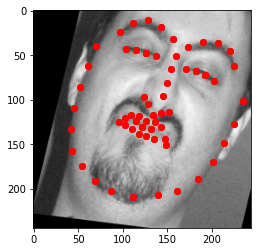

In [12]:
sample = train_dataset_cpy[17920]
im = sample['image']
keypts = sample['landmarks']
show_im_w_pts(im, keypts)
plt.scatter(keypts[:, 0], keypts[:, 1],c='red')
plt.imshow(im, cmap='gray')

CNN

In [7]:
import torchvision.models as models
import torch

def predict(net, im):
  input = torch.unsqueeze(torch.from_numpy(im), 0)
  out = net(input.float().to('cuda'))
  return out

def eval(net, criterion, sample):
  # Get target coordinates
  keypts = sample['landmarks'][0]
  keypts = np.array(keypts).flatten()
  target = torch.from_numpy(keypts)
  target = torch.unsqueeze(target, 0).float().to('cuda')
  # Get input image
  input = torch.unsqueeze(torch.from_numpy(np.array(sample['image'][0])), 0)
  input = torch.unsqueeze(input, 0)
  out = net(input.float().to('cuda'))

  # Compute loss
  loss = criterion(out, target).float().to('cuda')
  return out, loss

def fit(net, criterion, optimizer, sample):
  # Reset optimizer gradient
  optimizer.zero_grad()
  out, loss = eval(net, criterion, sample)
  loss.backward()
  optimizer.step()
  return out, loss


In [22]:
resnet18 = models.resnet18(pretrained=True)
# Modify input/output of ResNet18 nn
resnet18.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7,7), stride=(2,2), padding=(2,2), bias=False)
resnet18.fc = torch.nn.Linear(512 * resnet18.layer1[0].expansion, 136)
resnet18 = resnet18.float()
resnet18.to('cuda')

NameError: ignored

Training block

In [185]:
# just for testing out the nn, don't use
trial_dataset_t = LandmarkDataset(0, 10)
trial_dataset_v = LandmarkDataset(10, 20)


In [16]:
# initialize loss arrays in seperate cell in case need to add epochs
train_losses = []
validate_losses = []

In [ ]:
# Reload a saved model
model = models.resnet18(pretrained=True)
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7,7), stride=(2,2), padding=(2,2), bias=False)
model.fc = torch.nn.Linear(512 * model.layer1[0].expansion, 136)
model = model.float()
model.to('cuda')
model.load_state_dict(torch.load('/content/model_021114.pt'))
model.train() # set to train


# Loss function
criterion = torch.nn.MSELoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # learning rate=1e-3


In [ ]:

train_dataset = LandmarkDataset(0, 6000) # imgs 0-5999
# train_dataset_cpy = LandmarkDataset(0, 6000, ims=train_dataset.imgs[:], lndmrks=train_dataset.landmarks[:])
validation_dataset = LandmarkDataset(6000) # imgs 6000-6665

# initialize loss arrays in seperate cell in case need to add epochs
train_losses = []
validate_losses = []


print('Training began at: '+time.strftime('%D %H:%M:%S'))
for k in range(10):
    train_dataset_cpy = LandmarkDataset(0, 6000, ims=train_dataset.imgs[:], lndmrks=train_dataset.landmarks[:])
    augment_dataset(train_dataset_cpy, 1)

    # Prepare dataloaders
    dataloader_t = DataLoader(train_dataset_cpy, batch_size=100)
    dataloader_v = DataLoader(validation_dataset)

    root_imname = '/content/training_out/'

    # Training loop
    t0 = time.time()
    num_epochs = 25
    save_imgs_start_ind = 5000 # arbtitrary, just want some images
    save_imgs_end_ind = 5020
    for i in range(num_epochs):
        if i % 10 == 0:
            # Save model
            torch.save(model.state_dict(), '/content/model_TH'+time.strftime('%H%M%S')+'.pt')
            print('saved model on epoch '+ str(i))
        t2 = time.time()
        running_loss = 0.0
        # Run model fitting and get training error over training dataset
        for sample_ind, sample in enumerate(dataloader_t):
              out, loss = fit(model, criterion, optimizer, sample)
              running_loss = running_loss + loss.item()
              if i == num_epochs - 1 and sample_ind > save_imgs_start_ind and sample_ind < save_imgs_end_ind:
                  try:
                      out_pts_flat = out.tolist()[0]
                      out_pts = np.array([out_pts_flat[::2], out_pts_flat[1::2]]).T
                      sample_landmarks = np.array(sample['landmarks'].tolist()[0])
                      save_im_w_pts(sample['image'][0], sample_landmarks, root_imname+'t'+str(sample_ind)+'.jpg', out_pts)
                      fullsize_im, fullsize_landmarks = get_original_image_w_pts(sample_landmarks, train_dataset_cpy, sample_ind, img_filenames, bboxes)
                      fullsize_im, fullsize_predictions = get_original_image_w_pts(out_pts, train_dataset_cpy, sample_ind, img_filenames, bboxes)
                      save_im_w_pts(fullsize_im, fullsize_landmarks, root_imname+'full_t'+str(sample_ind)+'.jpg', fullsize_predictions)
                  except:
                      pass
        train_losses.append(running_loss/(len(dataloader_t)*68))
        print('Epoch #', len(train_losses), 'training error:', running_loss/(len(dataloader_t)*68))

        # Get validation error over validation dataset
        running_loss = 0.0
        for sample_ind, sample in enumerate(dataloader_v):
            out, loss = eval(model, criterion, sample)
            running_loss = running_loss + loss.item()
            if i == num_epochs - 1 and sample_ind > save_imgs_start_ind and sample_ind < save_imgs_end_ind:
                try:
                    out_pts_flat = out.tolist()[0]
                    out_pts = np.array([out_pts_flat[::2], out_pts_flat[1::2]]).T
                    sample_landmarks = np.array(sample['landmarks'].tolist()[0])
                    save_im_w_pts(sample['image'][0], sample_landmarks, root_imname+'v'+str(sample_ind)+'.jpg', out_pts)
                    fullsize_im, fullsize_landmarks = get_original_image_w_pts(sample_landmarks, validation_dataset, sample_ind, img_filenames, bboxes)
                    fullsize_im, fullsize_predictions = get_original_image_w_pts(out_pts, validation_dataset, sample_ind, img_filenames, bboxes)
                    save_im_w_pts(fullsize_im, fullsize_landmarks, root_imname+'full_v'+str(sample_ind)+'.jpg', fullsize_predictions)          
                except:
                    pass
        validate_losses.append(running_loss/(len(dataloader_v)*68))
        print('Validation error:', running_loss/(len(dataloader_v)*68))
        t3 = time.time()
        print('EPOCH #'+ str(i+1)+' runtime: ' + str(t3-t2))

    t1 = time.time()
    print('PART 2 TOTAL TIME TO RUN '+ str(num_epochs)+' EPOCHS: ' + str(t1-t0))
print('Training ended at: '+time.strftime('%D %H:%M:%S'))
# Save model
torch.save(model.state_dict(), '/content/model_'+time.strftime('%H%M%S')+'.pt')

Loss plot

In [32]:
# Plot result loss for part 2
plt.xlabel('Epoch #')
plt.ylabel('Epoch Loss')
plt.plot(train_losses, color='r', label='train')
plt.plot(validate_losses, color='g', label='validate')
plt.savefig('/content/loss_'+time.strftime('%H%M%S')+'.jpg')
plt.close()

Prediction block

In [33]:
#model = resnet18
model.eval()

dataloader_test = DataLoader(test_dataset)
with torch.no_grad():
  test_keypt_predictions = []
  save_imgs_start_ind = 0 # arbtitrary, just want some images
  save_imgs_end_ind = 100
  root_imname = '/content/prediction_out/'
  for sample_ind, sample in enumerate(dataloader_test):
    im = sample.numpy()
    # Run model on the test image
    out = predict(model, im)
    out_pts_flat = out.tolist()[0]
    out_pts = np.array([out_pts_flat[::2], out_pts_flat[1::2]]).T
    test_keypt_predictions.append(out_pts)
    # Save some of the predictions plotted on their images
    if sample_ind > save_imgs_start_ind and sample_ind < save_imgs_end_ind:
      save_im_w_pts(im[0], out_pts, root_imname+'p'+str(sample_ind)+'.jpg') 
      fullsize_im, fullsize_predictions = get_original_image_w_pts(out_pts, test_dataset, sample_ind, img_filenames_t, bboxes_t)
      save_im_w_pts(fullsize_im, fullsize_predictions, root_imname+'full_p'+str(sample_ind)+'.jpg')          
    

Saving to .csv

In [34]:
def to_csv(keypoints_lst, fname="/content/predictions.csv"):
  ids = np.arange(len(keypoints_lst))
  csv_array = np.zeros((len(keypoints_lst), 2))
  csv_array[:,0] = ids.astype(int)
  csv_array[:,1] = keypoints_lst
  np.savetxt(fname, csv_array, delimiter=',')

In [35]:
test_keypt_predictions_cpy = []
for keypts in test_keypt_predictions:
  for pt in keypts:
    test_keypt_predictions_cpy.append(pt[0])
    test_keypt_predictions_cpy.append(pt[1])
print(len(test_keypt_predictions_cpy))
to_csv(test_keypt_predictions_cpy)

137088


In [36]:
import csv
with open('/content/predictions.csv',newline='') as f:
    r = csv.reader(f)
    data = [line for line in r]
with open('/content/predictions_wheader.csv','w',newline='') as f:
    w = csv.writer(f)
    w.writerow(['Id','Predicted'])
    w.writerows(data)

dataset length:  10
augmented dataset length:  20


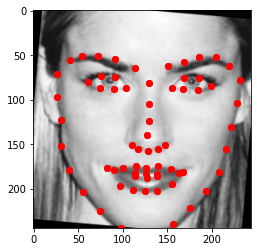

In [129]:
dataset = LandmarkDataset(6656)
print('dataset length: ', len(dataset.landmarks))
augment_dataset(dataset)
print('augmented dataset length: ', len(dataset.landmarks))
sample = dataset[17]
im = sample['image']
keypts = sample['landmarks']
show_im_w_pts(im, keypts)
plt.scatter(keypts[:, 0], keypts[:, 1],c='red')

plt.imshow(im, cmap='gray')
# save_im_w_pts(im, keypts, '/content/dataloader_out/test1.jpg')

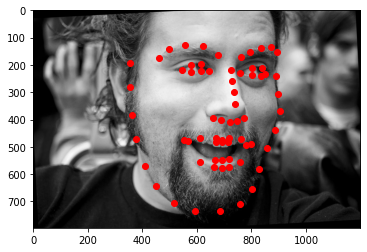

In [128]:
# dataset = LandmarkDataset(6656)
sample = dataset[5]
im = sample['image']
keypts = sample['landmarks']
im, keypts = get_original_image_w_pts(keypts, dataset, 5)
im, keypts = rand_transform(im, keypts)
plt.scatter(keypts[:, 0], keypts[:, 1],c='red')
plt.imshow(im, cmap='gray')

[  0 185 478 536]
1008 (1008, 4) ibug_300W_large_face_landmark_dataset/helen/trainset/146827737_1.jpg


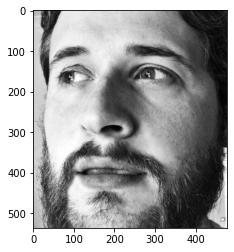

In [20]:
# test dataset testing
im_t = sk.color.rgb2gray(skio.imread(img_filenames_t[15]))
bbox_t = bboxes_t[15].astype(int)
im_t = crop_img(im_t, bbox_t)
print(bbox_t)
# im_t = resize_img(im_t, 244)
print(len(img_filenames_t), bboxes_t.shape, img_filenames_t[0])
plt.close()
plt.imshow(im_t, cmap='gray')

(6666, 68, 2) (6666, 4) 6666
[570.  52. 180. 180.]
100.31111 [ 55. 141.]


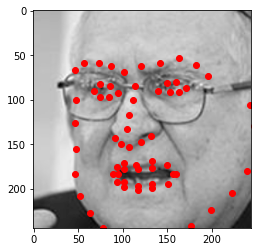

In [72]:


print(landmarks.shape, bboxes.shape, len(img_filenames))
print(bboxes[1599])
im = sk.color.rgb2gray(skio.imread(img_filenames[1599]))
bbox = bboxes[1599].astype(int)
resize_dim = 244

im = crop_img(im, bbox)
to_plot_x, to_plot_y = crop_resize_keypts(landmarks[1599], bbox, resize_dim, im.shape)
print(to_plot_y[0], landmarks[0][0])
im = resize_img(im, resize_dim)

# im = im[bbox[1]:bbox[1]+bbox[3],bbox[0]:bbox[0]+bbox[2]]
# to_plot_x = landmarks[1599][:,0] - bbox[0]
# to_plot_y = landmarks[1599][:,1] - bbox[1]
# scalar = resize_dim*1.0 / im.shape[0]
# print(scalar)
# to_plot_x = to_plot_x*scalar
# to_plot_y = to_plot_y*scalar
# im = resize(im, (resize_dim, resize_dim))
plt.scatter(to_plot_x, to_plot_y, c='red')
plt.imshow(im, cmap='gray')

In [69]:
print(1008*68*2)
print(len(img_filenames_t))
testnp = np.array([[1.11,2.11,1.12,2.12], [1.21,2.21,1.22,2.22]])
testnp2 = np.zeros((4,2))
testnp2[:, 0] = testnp[0]
testnp2[:, 1] = testnp[1]
print(testnp2.insert())
# print(testnp.flatten())
# test_flat = []
# [test_flat.extend(keypts) for  keypts in testnp]
# print(test_flat)
# print(np.zeros((4,2)))
# to_csv(testnp,2)

137088
1008
[[1.11 1.21]
 [2.11 2.21]
 [1.12 1.22]
 [2.12 2.22]]
